# Generating Images with Variational Autoencoders

## Sampling from latent spaces of images

Variational autoencoders, simultaneously discovered by Kingma & Welling in December 2013, and Rezende, Mohamed & Wierstra in January 2014, are a kind of generative model that is especially appropriate for the task of image editing via concept vectors. They are a modern take on autoencoders -- a type of network that aims to "encode" an input to a low-dimensional latent space then "decode" it back -- that mixes ideas from deep learning with Bayesian inference.

A classical image autoencoder takes an image, maps it to a latent vector space via an "encoder" module, then decode it back to an output with the same dimensions as the original image, via a "decoder" module. It is then trained by using as target data the same images as the input images, meaning that the autoencoder learns to reconstruct the original inputs. By imposing various constraints on the "code", i.e. the output of the encoder, one can get the autoencoder to learn more or less interesting latent representations of the data. Most commonly, one would constraint the code to be very low-dimensional and sparse (i.e. mostly zeros), in which case the encoder acts as a way to compress the input data into fewer bits of information.

![](assets/autoencoder_schema.jpg)

In practice, such classical autoencoders don't lead to particularly useful or nicely structured latent spaces. They are not much good at compression, either. For these reasons, they have largely fallen out of fashion. VAEs, however, augment autoencoders with a little bit of statistical magic that forces them to learn continuous, highly structured latent spaces. They have turned out to be a powerful tool for image generation.

A VAE, instead of compressing its input image into a fixed code in the latent space, turns the image into the parameters of a statistical distribution:
- a mean and
- a variance

Essentially, this means you are assuming the input image has been generated by a statistical process, and that the randomness of this process should be taken into accounting during encoding. The VAE then uses the mean and variance parameters to randomly sample one element of the distribution, and decodes that element back to the original input. The stochasticity of this process improves robustness and forces the latent space to encode meaningful representations everywhere: every point sampled in the latent space is decoded to a valid output.

![](assets/vae2.jpg)

In technical terms, here is how a VAE works:

1. An encoder module turns the input samples `input_img` into two parameters in a latent space of representations, `z_mean`, and `z_log_variance`.

2. You randomly sample a point `z` from the latent normal distribution that is assumed to generate the input image, via `z = z_mean + exp(z_log_variance) * epsilon`, where `epsilon` is a random tensor of small values. 

3. A decoder module maps this point in the latent space back to the original input image

Because `epsilon` is random, the process ensures that every point that is close to the latent location where you encoded `input_img(z-mean)` can be decoded to something similar to `input_img`, thus forcing the latent space to be continuously meaningful. Any two close points in the latent space will decode to highly similar images. Continuity, combined with the low dimensionality of the latent space, forces every direction in the latent space to encode a meaningful axis of variation of the data, making the latent space very structured and thus highly suitable to manipulation via concept vectors.


The parameters of a VAE are trained via two loss functions:
- a *reconstruction loss* that forces the decoded samples to match the initial inputs and
- a *regularization loss* that helps learn well-formed latent  spaces and reduce overfitting to the training data.

Let's quickly go over a Keras implementation of a VAE schematically, it looks like this:

```python
z_mean, z_log_variance = encoder(input_img) # Encodes the input ito a mean and variance parameter

z = z_mean + exp(z_log_variance) * epsilon # Draw a latent point using a small random epsilon

reconstructed_img = decoder(z)  # Decodes z back to an image

# Instantiates the autoencoder model, which maps an input imageto its reconstruction
model = Model(input_img, reconstructed_img) 
```

## VAE encoder network

In [3]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

Using TensorFlow backend.


In [4]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2 # Dimensionality of the latent space: a 2D plane

In [5]:
input_img = keras.Input(shape=img_shape)

In [6]:
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

In [7]:
shape_before_flattening = K.int_shape(x)

In [8]:
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

In [10]:
# The input ends up being encoded into these two parameters
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

Next is the code for using `z_mean` and `z_log_var`, the parameters of the statistical distribution assumed to have produced `input_img`, to generate a latent space point `z`. Here you wrap some arbitrary code (built on top of Keras backend primitives) into a `Lambda` layer. In Keras, everything needs to be a layer, so code that is not part of a built-in layer should be wrapped in a `Lambda`(or in a custom layer).

## Latent Space sampling function

In [11]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

In [12]:
z = layers.Lambda(sampling)([z_mean, z_log_var])

The following listings shows the decoder implementation. You reshape the vector z to the dimensions of an image and then use a few convolution layers to obtain a final image output that has the same dimensions as the original `input_img`.

## VAE decoder network, mapping latent space points to images

In [13]:
decoder_input = layers.Input(K.int_shape(z)[1:])  # Input where you will feed z
x = layers.Dense(
    np.prod(shape_before_flattening[1:]),
    activation='relu')(decoder_input)  # Upsamples the input

# Reshape z into a feature map of the same shape as the feature map just before the last Flatten layer in the encoder model
x = layers.Reshape(shape_before_flattening[1:])(x)

# Uses a a Conv2DTranspose layer and a Conv2D layer to decode z into a feature map the same size as the original image input
x = layers.Conv2DTranspose(
    32, 3, padding='same', activation='relu', strides=(2, 2))(x)

x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

In [14]:
# Instatiates the decoder model, which turns "decoder_input" into the decoded image
decoder = Model(decoder_input, x)

# Applies it to z to recover the decoded z
z_decoded = decoder(z)

The dual loss of a VAE doesn't fit the  traditional expectation of a sample-wise function of the form `loss(input, target)`. Thus, you will set up the loss by writing a custom layer that internally uses the built-in `add_loss` layer method to create an arbitrary loss.

## Custom layer used to compute the VAE loss

In [18]:
class CustomVariationalLayer(keras.layers.Layer):
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        k1_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + k1_loss)
    
    # Implement a custom layers by writing a call method
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        
        # You don't use this output, but the layer must return something
        return x

In [19]:
# Call the custom layer on the input and the decoded output to obtain the final output
y = CustomVariationalLayer()([input_img, z_decoded])

Finally, you are ready to instantiate and train the model. Because the loss is taken care of in the custom layer, you don't specify an external loss at compile time `(loss=None)`, which in turn means you won't pass target data during training.

## Training the VAE

In [20]:
from keras.datasets import mnist

In [23]:
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: UserWarning: Output "custom_variational_layer_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_2" during training.
  


In [24]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [27]:
(x_train, _), (x_test, y_test) = mnist.load_data()
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [28]:
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_train.shape

(60000, 28, 28, 1)

In [30]:
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))
x_test.shape

(10000, 28, 28, 1)

In [31]:
%%time
vae.fit(x=x_train,  y=None,
       shuffle=True,
       epochs=10,
       batch_size=batch_size,
       validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 53s 878us/step - loss: 3054.5342 - val_loss: 0.1299
Epoch 2/10
60000/60000 [==============================] - 52s 861us/step - loss: 0.1922 - val_loss: 0.1189
Epoch 3/10
60000/60000 [==============================] - 52s 862us/step - loss: 0.1886 - val_loss: 0.1537
Epoch 4/10
60000/60000 [==============================] - 52s 863us/step - loss: 0.1865 - val_loss: 0.1167
Epoch 5/10
60000/60000 [==============================] - 52s 863us/step - loss: 0.1850 - val_loss: 0.1502
Epoch 6/10
60000/60000 [==============================] - 52s 862us/step - loss: 0.1839 - val_loss: 0.1312
Epoch 7/10
60000/60000 [==============================] - 52s 862us/step - loss: 0.1831 - val_loss: 0.1244
Epoch 8/10
60000/60000 [==============================] - 52s 862us/step - loss: 0.1823 - val_loss: 0.1107
Epoch 9/10
60000/60000 [==============================] - 52s 861us/step - loss: 0.1816 - v

## Sampling a grid of points from the 2D latent space and decoding them to images

Once such a model is trained -- on MNIST, in this case--you can use the `decoder` network to turn arbitrary latent space vectors into images. 

In [32]:
import matplotlib.pyplot as plt 
%matplotlib inline
from scipy.stats import norm 

In [33]:
n = 20 # we will dislay a grid of 15 x 15 digits (400)
digit_size = 28


In [34]:
figure = np.zeros((digit_size * n, digit_size * n))

# Transform linearly spaced coordinates using the SciPy ppf function to produce values of latent variable z 
# (because the prior of the latent space is Gaussian)
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

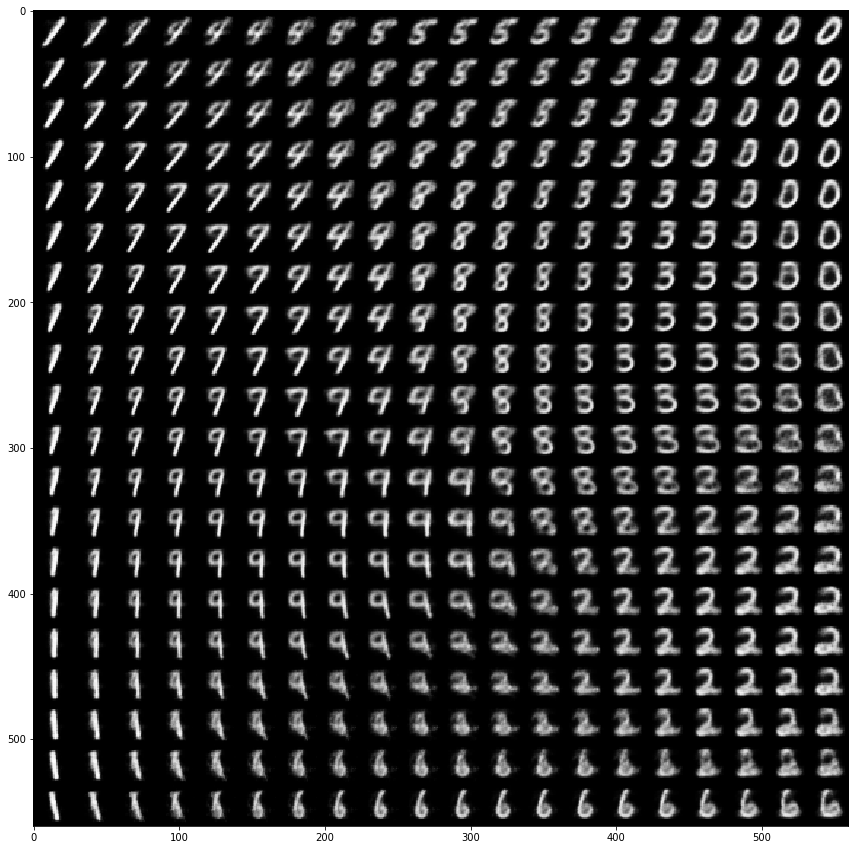

In [35]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([xi, yi])
        # Repeats z multiple times to from a complete batch
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        
        # Decode the batch into digit images
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)

        # Reshape the first digit in the batch from 28x28x1 to 28x28
        digit = x_decoded[0].reshape(digit_size, digit_size)

        figure[i * digit_size:(i + 1) * digit_size, 
               j * digit_size:(j + 1) * digit_size] = digit 
        
plt.figure(figsize=(15, 15))
plt.imshow(figure, cmap='Greys_r')
plt.show()
        



The grid of sampled digits shows a completely continuous distribution of the different digit classes, with one digit morphing into another as you follow a path through latent space. Specific directions in this space have a meaning, e.g. there is a direction for "four-ness", "one-ness", etc.


## Key Takeaways


- Image generation with deep learning is done by learning latent spaces that capture statistical information about a dataset of images. By sampling and decoding points from the latent space, you can generate never-before-seen images. There are two major tools to do this: VAEs and GANs.
- VAEs result in highly structured, continuous latent representations. For this reason, they work well for doing all sorts of image editing in latent space: face swapping, turning a frowning face into a smiling face, and so on. They also work nicely for doing latent-space-based animations, such as animating a walk along a cross section of the latent space, showing a starting image slowly morphing into different images in a continuous way.
- GANs enable the generation of realistic single-frame images but may not induce latent spaces with solid structure and high continuity.

Most successful practical applications rely on VAEs, but GANs are extremely popular in the world of academic research—at least, circa 2016–2017.


**Tip**

To play further with image generation, I suggest working with the Large-scale Celeb Faces Attributes (CelebA) dataset. It’s a free-to-download image dataset containing more than 200,000 celebrity portraits. It’s great for experimenting with concept vectors in particular—it definitely beats MNIST.


In [36]:
%load_ext version_information
%version_information scipy, numpy, keras, matplotlib, tensorflow

Software versions
Python 3.5.2 64bit [GCC 5.4.0 20160609]
IPython 6.2.1
OS Linux 4.4.0 1048 aws x86_64 with Ubuntu 16.04 xenial
scipy 1.0.0
numpy 1.14.0
keras 2.1.2
matplotlib 2.1.0
tensorflow 1.3.0
Sun Jan 14 23:29:41 2018 UTC